In [46]:
## Control Downloading fresh data
DOWNLOAD_DATA = False

# OBTAIN

### DATA SOURCES:

* **All Donald Trump tweets from 12/01/2016 (pre-inaugaration day) ~~to end of 08/23/2018~~**
    *          ~~Extracted from http://www.trumptwitterarchive.com/~~
    - Trump Twitter Archive 2.0 (now with API endpoint)
    - https://www.thetrumparchive.com/

* **Minute-resolution data for the S&P500 covering the same time period.**
    *         IVE S&P500 Index from - http://www.kibot.com/free_historical_data.aspx
    - (***Aggregate 1 min bid-ask data link***)
        - http://api.kibot.com/?action=history&symbol=IVE&interval=tickbidask1&bp=1&user=guest
    
    
* NOTE: Both sources required manual extraction and both 1-min historical stock data and batch-historical-tweet data are difficult to obtain without paying \\$150-\\$2000 monthly developer memberships. 

In [4]:
import os,sys,glob,time
sys.path.append('py_files/')

## IMPORT CUSTOM CAPSTONE FUNCTIONS
import functions_combined_BEST as ji
import functions_io as io

## Import data downloading packages
import datetime as dt
import requests
import pandas as pd
import json

In [6]:
# !pip install -U fsds
from fsds.imports import *

fsds v0.2.27 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


In [7]:
def download_stock_data(fpath='data/ive_minute_tick_bidask_API.csv',
                       verbose=True,append_date=True):
    """Downloads up-to-date IVE S&P 500 1-min aggregate data from 
    http://www.kibot.com/free_historical_data.aspx
    
    Args:
        fpath (str): csv filepath to save (Default='data/ive_minute_tick_bidask_API.csv')
        verbose (bool): Display file info (Default=True)
        
    Returns:
        stock_df: DataFrame with correct headers and datetime index"""
    agg_url = 'http://api.kibot.com/?action=history&symbol=IVE&interval=tickbidask1&bp=1&user=guest'
    response = requests.get(agg_url,
                            allow_redirects=True)

    ## Save output to csv file
    with open(fpath,'wb') as file:
        file.write(response.content)
        
        
    ## Load in Stock Data Frame with headers (then save)
    headers = ['Date','Time','BidOpen','BidHigh','BidLow','BidClose','AskOpen','AskHigh','AskLow','AskClose']
    stock_df = pd.read_csv(fpath,names=headers)

# 
    ## Make Combined Date Time column and Drop Origs
    stock_df['datetime'] = pd.to_datetime(stock_df['Date'].astype(str)+' '+stock_df['Time'].astype(str))
    
    if append_date:
        suffix = dt.date.today().strftime('%m-%d-%y')
        fpath = f"{fpath.split('.csv')[0]}_{suffix}.csv"
        
    print(f'Saving as {fpath}')
    stock_df.to_csv(fpath,index=False)
        
    if verbose:
        print('[i] Stock data successfully downloaded and saved as:')
        print(' - ',fpath)
        
    return pd.read_csv(fpath,parse_dates=['datetime'],index_col='datetime')

In [17]:
def download_trump_tweets(fpath='data/trump_tweets.csv',append_date=True,
                          verbose=True,return_data=True):
    """Downloads the most recent data from the trumptwittearchive v2.
    https://drive.google.com/uc?export=download&id=1JZnhB0Nq_2RKtDb-IOnd0XxnD5c7x-nQ
    
    Args:
        fpath (str): filepath for data that ends with .csv
        append_date (bool): Whether to save today's date as part of filename(Default=True)
        verbose (bool): Whether to print the file name (Default=True)
        return_data (bool): Whether to return the data as a df (Default=True)"""
#     url = "https://www.thetrumparchive.com/latest-tweets"
    url="https://drive.google.com/uc?export=download&id=1JZnhB0Nq_2RKtDb-IOnd0XxnD5c7x-nQ"
    response = requests.get(url)
    
    if append_date:
        suffix = "_"+dt.date.today().strftime('%m-%d-%y')
        filepath = f"{fpath.split('.')[0]}{suffix}.{fpath.split('.')[-1]}"
    else:
        filepath=fpath
        
        
    ## Save output to csv file
    with open(filepath,'wb') as file:
        file.write(response.content)  
        
#     with open(filepath,'w') as f:
# #         f.write(response.content)
#         f.write(json.dumps(response.json()))
    
#     if fpath.endswith('.csv'):
#         tweets = pd.read_json(filepath)
#         tweets.to_csv(filepath)
#     else: 
#         tweets = pd.read_json(filepath)
        
    if verbose:
        print('[i] Tweet data successfully downloaded and saved as:')
        print('- ',filepath)
        
    if return_data:

        return pd.read_csv(filepath,index_col=0,parse_dates=['date'])
#tweets#,parse_dates=['created_at'])

In [59]:
## DOWNLOAD THE DATA IF REQUESTED
if DOWNLOAD_DATA:
    print('[i] Downoading data sets...')
    stock_df = download_stock_data()
    tweets = download_trump_tweets()
    
else: 
    print('[i] Loading most recent data sets...')
    ## Get list of current csvs
    files_glob = glob.glob('data/*.csv')
    stock_files = list(filter(lambda x: 'ive_minute' in x, files_glob))
    tweet_files = list(filter(lambda x: 'tweet' in x, files_glob))


    ## make dictionaries of file date modifieds
    TWEET_FILES = {}
    for file in tweet_files:
        TWEET_FILES[file] = pd.to_datetime(time.ctime(os.path.getmtime(file)))

    STOCK_FILES = {}
    for file in stock_files:
        STOCK_FILES[file] = pd.to_datetime(time.ctime(os.path.getmtime(file)))

        
    ## Get most recent files
    recent_stocks = pd.Series(STOCK_FILES).idxmax()
    recent_tweets = pd.Series(TWEET_FILES).idxmax()
    
    ## Load in the csvs 
    tweets = pd.read_csv(recent_tweets,parse_dates=['date'])
    stock_df = pd.read_csv(recent_stocks,parse_dates=['datetime'],index_col='datetime')

## Display Preview of DFs
display(stock_df.head(),tweets.head())

[i] Loading most recent data sets...


,Date,Time,BidOpen,BidHigh,BidLow,BidClose,AskOpen,AskHigh,AskLow,AskClose
datetime,,,,,,,,,,
2009-09-28 09:30:00,09/28/2009,09:30,39.06,39.06,39.06,39.06,39.13,39.13,39.13,39.13
2009-09-28 09:31:00,09/28/2009,09:31,39.10,39.10,39.08,39.09,39.11,39.11,39.10,39.11
2009-09-28 09:32:00,09/28/2009,09:32,39.11,39.15,39.11,39.15,39.12,39.16,39.12,39.16
2009-09-28 09:33:00,09/28/2009,09:33,39.14,39.14,39.14,39.14,39.15,39.16,39.15,39.15
2009-09-28 09:34:00,09/28/2009,09:34,39.14,39.14,39.12,39.12,39.15,39.15,39.14,39.14


,id,text,isRetweet,isDeleted,device,favorites,retweets,date
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59


In [60]:
stock_df.shape, tweets.shape

((913056, 10), (54442, 8))

# Creating the Target

## Stock Preprocessing

In [61]:
stock_df = stock_df[['BidClose']].reset_index()#.asfreq('T')
stock_df

,datetime,BidClose
0,2009-09-28 09:30:00,39.06
1,2009-09-28 09:31:00,39.09
2,2009-09-28 09:32:00,39.15
3,2009-09-28 09:33:00,39.14
4,2009-09-28 09:34:00,39.12
...,...,...
913051,2020-10-23 15:56:00,116.83
913052,2020-10-23 15:57:00,116.86
913053,2020-10-23 15:58:00,116.82
913054,2020-10-23 15:59:00,116.87


In [62]:
stock_df.isna().sum()

datetime    0
BidClose    0
dtype: int64

In [66]:
# ## Remove rare 0-values
stock_df = stock_df[~(stock_df==0).any(axis=1)]
stock_df.shape

(913039, 2)

In [67]:
(stock_df==0).sum()

datetime    0
BidClose    0
dtype: int64

In [68]:
stock_df.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            913046, 913047, 913048, 913049, 913050, 913051, 913052, 913053,
            913054, 913055],
           dtype='int64', length=913039)

<AxesSubplot:xlabel='datetime'>

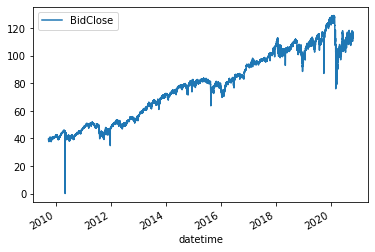

In [70]:
stock_df.plot('datetime','BidClose')

## Tweet Processing

In [72]:
display(tweets.head(),tweets.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54442 entries, 0 to 54441
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         54442 non-null  int64         
 1   text       54442 non-null  object        
 2   isRetweet  54442 non-null  object        
 3   isDeleted  54442 non-null  object        
 4   device     54442 non-null  object        
 5   favorites  54442 non-null  int64         
 6   retweets   54442 non-null  int64         
 7   date       54442 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 3.3+ MB


,id,text,isRetweet,isDeleted,device,favorites,retweets,date
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59


None

In [73]:
# ## Train Test Split
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train,y_test = train_test_split(X,y,random_state=42)

In [14]:
# df.index